# 实验7 基于序列模型的中英文翻译机

姓名：刘清

学号：202021045838

学院：软件学院

班级：软件工程专硕3班

## 1 - 导入必要的包

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import jieba
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from pylab import mpl


myfont = fm.FontProperties(fname=r'C:Windows\Fonts\simhei.ttf')
mpl.rcParams['font.sans-serif'] = ['SimHei']

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 2 - 加载数据文件

定义无法识别的单词、句尾及语言类:

In [2]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS单词总量 初始化包含 SOS and EOS
    
    # 处理英文句子
    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)
    
    # 处理中文句子
    def addSentence_cn(self, sentence):
        for word in list(jieba.cut(sentence)):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

这些文件都是Unicode格式，为了简化我们将Unicode字符转换为ASCII，使所有内容都小写，并去掉大多数标点符号。

In [3]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    #s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

## 2.1 读取数据文件

要读取数据文件，我们将文件拆分为行，然后将行拆分成对。 这些文件都是英语——>其他语言，所以如果我们想翻译其他语言→英语，我添加 reverse标志来反转对。

In [4]:
def readLangs(lang1,lang2,reverse=False):
    print("Reading lines...")
    # 读文件，然后分成行
    lines = open('%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')
    # 把行分成句子对，并进行规范化
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    # 判断是否需要转换语句的次序，如[英文，中文]转换为[中文，英文]次序
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)
    return input_lang, output_lang, pairs

由于有很多例句，我们想快速训练，我们会将数据集修剪成相对简短的句子。 这里最大长度是10个单词（包括结束标点符号），我们将过滤到 转换为“我是”或“他是”等形式的句子（考虑先前替换的撇号）。

In [5]:
MAX_LENGTH = 20

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p, reverse):

    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes) if reverse else p[0].startswith(eng_prefixes)


def filterPairs(pairs, reverse):
    return [pair for pair in pairs if filterPair(pair, reverse)]

准备数据的完整过程是：

* 读取文本文件并拆分成行，将行拆分成对
* 规范化文本，按长度和内容进行过滤
* 从成对的句子中制作单词列表

In [6]:
# 把以上数据预处理函数，放在一起，实现对数据的预处理
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    
    print('Read %s sentence pairs' % len(pairs))
    pairs = filterPairs(pairs, reverse)
    print('Trimmed to %s sentence pairs' % len(pairs))
    print('Counting words...')
    for pair in pairs:
        if reverse:
            input_lang.addSentence_cn(pair[0])
            output_lang.addSentence(pair[1])
        else:
            input_lang.addSentence(pair[0])
            output_lang.addSentence_cn(pair[1])
    print('Counted words:')
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

#运行预处理函数
reverse = False
input_lang, output_lang, pairs = prepareData('eng','cmn', reverse)


Reading lines...


Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\Rico\AppData\Local\Temp\jieba.cache


Read 24026 sentence pairs
Trimmed to 689 sentence pairs
Counting words...


Loading model cost 0.582 seconds.
Prefix dict has been built successfully.


Counted words:
eng 833
cmn 1107


## 3 - Seq2Seq模型

循环神经网络（RNN）是一种对序列进行操作的网络，它使用自己的输出作为后续步骤的输入。Sequence to Sequence network(seq2seq网络)或Encoder-Decoder network是由称为编码器和解码器的两个RNN组成的模型。编码器读取输入序列并输出单个向量，并且解码器读取该向量以产生输出序列。

与使用单个RNN的序列预测不同，其中每个输入对应于输出，seq2seq模型使我们从序列长度和顺序中解放出来，这使其成为两种语言之间转换 的理想选择。

使用seq2seq模型，编码器创建单个向量，在理想情况下，将输入序列的“含义”编码为单个向量 - 句子的某些N维空间中的单个点。

### 3.1 编码器

seq2seq网络的编码器是RNN，它为输入句子中的每个单词输出一些值。对于每个输入的词，编码器输出向量和隐藏状态，并将隐藏状态用于下 一个输入的单词。

In [7]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### 3.2 解码器

解码器是另一个RNN，它接收编码器输出向量并输出一系列字以创建转换。

简单的解码器 在最简单的seq2seq解码器中，我们仅使用编码器的最后一个输出。 最后一个输出有时称为上下文向量，因为它编码整个序列的上下文。 该上下文向量用作解码器的初始隐藏状态。

在解码的每个步骤中，给予解码器输入token和隐藏状态。初始输入token是开始字符串`<SOS>`标记，第一个隐藏状态是上下文向量（编码器 的最后隐藏状态）。

In [8]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### 3.3 注意力机制

如果仅在编码器和解码器之间传递上下文向量，则该单个向量承担编码整个句子的信息。

注意力允许解码器网络针对解码器自身输出的每个步骤“聚焦”编码器输出的不同部分。首先，我们计算一组注意力权重。这些将乘以编码器 输出向量以创建加权组合。结果（在代码中称为`attn_applied`）应包含有关输入序列特定部分的信息，从而帮助解码器选择正确的输出单词。

使用解码器的输入和隐藏状态作为输入，使用另一个前馈层`attn`来计算注意力权重。因为训练数据中存在所有不同大小的句子，为了实际创建和 训练该层，我们必须选择它可以应用的最大句子长度（输入长度，对于编码器输出）。最大长度的句子将使用所有注意力权重，而较短的句子将 仅使用前几个。

In [9]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## 4 - 训练

### 4.1 准备训练数据

为了训练，对于每对翻译对，我们将需要输入张量（输入句子中的单词的索引）和目标张量（目标句子中的单词的索引）。在创建这些向量时， 我们会将EOS标记附加到两个序列。

In [10]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def indexesFromSentence_cn(lang, sentence):
    return [lang.word2index[word] for word in list(jieba.cut(sentence))]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorFromSentence_cn(lang, sentence):
    indexes = indexesFromSentence_cn(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair, reverse):
    if reverse:
        input_tensor = tensorFromSentence_cn(input_lang, pair[0])
        target_tensor = tensorFromSentence(output_lang, pair[1])
    else:
        input_tensor = tensorFromSentence(input_lang, pair[0])
        target_tensor = tensorFromSentence_cn(output_lang, pair[1])
    return (input_tensor, target_tensor)

### 4.2 训练模型

为了训练我们通过编码器运行的输入句子，并跟踪每个输出和最新的隐藏状态。然后，解码器被赋予标记作为其第一输入，并且编码器的 最后隐藏状态作为其第一隐藏状态。

“Teacher Forcing”是将真实目标输出用作每个下一个输入的概念，而不是使用解码器的猜测作为下一个输入。使用teacher forcing使模型 更快地收敛，但是当利用受过训练的网络时，它可能表现出不稳定性。

您可以观察teacher forcing网络的输出，这些网络使用连贯的语法阅读，但远离正确的翻译 - 直觉上它已经学会表示输出语法，并且一旦 老师告诉它前几个单词就可以“提取”意义，但是它没有正确地学习如何从翻译中创建句子。

由于PyTorch的`autograd`为我们提供了自由，我们可以随意选择使用teacher forcing或不使用简单的if语句。将`teacher_forcing_ratio`调高以使用更多。

In [11]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

### 辅助函数

这是一个辅助函数，用于打印经过的时间和估计的剩余时间给定当前时间和进度％。

In [12]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

### 结果绘图函数

绘图使用 matplotlib 库完成，使用在训练时保存的`plot_losses`的损失值数组。

In [13]:
%matplotlib inline
# plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

整个训练过程如下：

* 启动计时器
* 初始化优化器和标准
* 创建一组训练对
* 启动空损数组进行绘图

然后我们调用`train`，偶尔打印进度（例子的百分比，到目前为止的时间，估计的时间）和平均损失。

In [14]:
def trainIters(encoder, decoder, n_iters, reverse, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  
    plot_loss_total = 0 

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs), reverse)
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)
    return plot_losses

### 评价函数

评估与训练大致相同，但没有目标，因此我们只需将解码器的预测反馈给每个步骤。每次它预测一个单词时我们都会将它添加到输出字符串中， 如果它预测了EOS标记，我们就会停在那里。我们还存储解码器的注意力输出以供稍后显示。

In [15]:
def evaluate(encoder, decoder, sentence, reverse, max_length=MAX_LENGTH):
    with torch.no_grad():
        if reverse:
            input_tensor = tensorFromSentence_cn(input_lang, sentence)
        else:
            input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

我们可以从训练集中评估随机句子并打印输入、目标和输出以做出一些直观质量判断：

In [15]:
def evaluate(encoder, decoder, sentence, reverse, max_length=MAX_LENGTH):
    with torch.no_grad():
        if reverse:
            input_tensor = tensorFromSentence_cn(input_lang, sentence)
        else:
            input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0], reverse)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [16]:
def evaluate_randomly():
    pair = random.choice(pairs)
    
    output_words, decoder_attn = evaluate(pair[0])
    output_sentence = ' '.join(output_words)
    
    print('>', pair[0])
    print('=', pair[1])
    print('<', output_sentence)
    print('')

def evaluateRandomly(encoder, decoder, n=20):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0], reverse)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

## 5 - 训练和评价

1m 34s (- 22m 5s) (5000 6%) 3.1706
3m 0s (- 19m 31s) (10000 13%) 1.3679
4m 28s (- 17m 53s) (15000 20%) 0.3349
5m 58s (- 16m 25s) (20000 26%) 0.1166
7m 25s (- 14m 50s) (25000 33%) 0.0742
8m 52s (- 13m 19s) (30000 40%) 0.0620
10m 20s (- 11m 49s) (35000 46%) 0.0564
11m 48s (- 10m 19s) (40000 53%) 0.0591
13m 16s (- 8m 50s) (45000 60%) 0.0559
14m 44s (- 7m 22s) (50000 66%) 0.0551
16m 13s (- 5m 53s) (55000 73%) 0.0476
17m 40s (- 4m 25s) (60000 80%) 0.0457
19m 9s (- 2m 56s) (65000 86%) 0.0458
20m 38s (- 1m 28s) (70000 93%) 0.0447
22m 7s (- 0m 0s) (75000 100%) 0.0487


<Figure size 432x288 with 0 Axes>

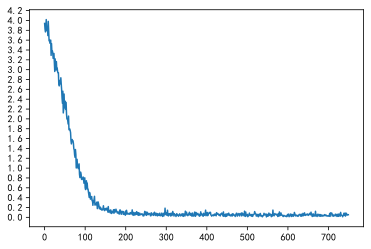

In [18]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

losses = trainIters(encoder1, attn_decoder1, 75000, reverse, print_every=5000)

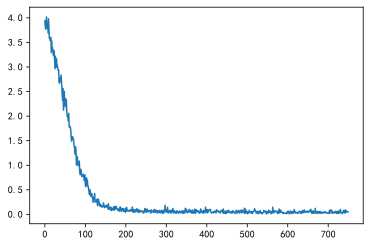

In [19]:
%matplotlib inline
from IPython import display
display.set_matplotlib_formats('svg')
plt.plot(losses)

In [20]:
evaluateRandomly(encoder1, attn_decoder1)

> he is good at riding a horse .
= 他擅長騎馬。
< 他 擅長 騎馬 。 <EOS>

> he is a doctor by profession .
= 他的职业是医生。
< 他 的 职业 是 医生 。 <EOS>

> she is ashamed of what she's done .
= 她为自己所做的事感到羞耻。
< 她 为 自己 所 做 的 事 感到 羞耻 。 <EOS>

> they are all innocent children .
= 他们都是天真的孩子。
< 他们 都 是 无辜 的 孩子 。 <EOS>

> he is very good at playing violin .
= 他非常擅長拉小提琴。
< 他 非常 擅長 拉 小提琴 。 <EOS>

> he is often absent from school .
= 他经常翘课。
< 他 经常 翘课 。 <EOS>

> she is giving the baby a bath .
= 她正在給嬰兒洗澡。
< 她 正在 給嬰兒 洗澡 。 <EOS>

> she is the one who feeds our dog .
= 她是喂我們的狗的人。
< 她 是 喂 我們 的 狗 的 人 。 <EOS>

> he is not stupid .
= 他不是傻子。
< 他 不是 傻子 。 <EOS>

> i am surprised that your family has a japanese car .
= 我很惊讶，你家居然有辆日本车。
< 我 很 惊讶 ， 你家 居然 有辆 日本 车 。 <EOS>

> he is a famous composer .
= 他是一位著名的作曲家。
< 他 是 一位 著名 的 作曲家 。 <EOS>

> she is proud that her son has become a doctor .
= 她为自己的儿子成为医生而自豪。
< 她 为 自己 的 儿子 成为 医生 而 自豪 。 <EOS>

> i am getting off at the next station .
= 我在下一站下车。
< 我 在 下 一站 下车 。 <EOS>

> he is wearing gloves .

## 6 - 可视化注意力

注意力机制的一个有用特性是其高度可解释的输出。因为它用于对输入序列的特定编码器输出进行加权，所以我们可以想象在每个时间步长看 网络最关注的位置。

In [32]:
import matplotlib

font = {'family': 'MicroSoft YaHei', 'weight': 'regular', 'size': '12'}
matplotlib.rc('font', **font)
# matplotlib.rc('font', family='Microsoft YaHei', weight='blod')

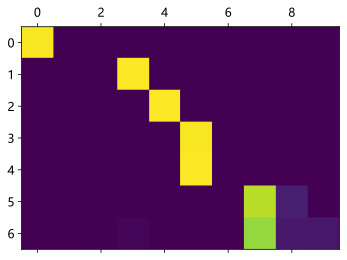

In [33]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "他 是 个 日 本 少 年 。")
plt.matshow(attentions.numpy())

为了获得更好的观看体验，我们将额外添加轴和标签：

input = i am so happy
output = 我 很 好奇 。 <EOS>
['我', '很', '好奇', '。', '<EOS>']


d:\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]
d:\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  


<Figure size 432x288 with 0 Axes>

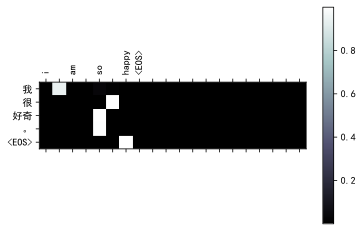

In [52]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    plt.rcParams['font.sans-serif']=['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    plt.clf()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + list(jieba.cut(input_sentence)) +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # plt.show()
    print(output_words)
    plt.savefig('result-%s.jpg' % input_sentence)

def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence, reverse)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("i am so happy")

## 使用nltk评估模型

In [43]:
from nltk.translate.bleu_score import sentence_bleu


bleu_score = 0.0
for pair in pairs:
    output_words, _ = evaluate(encoder1, attn_decoder1, pair[0], reverse=reverse)
    prediction = [output_lang.word2index[word] for word in output_words[:-1]]
    target = [output_lang.word2index[word] for word in jieba.cut(pair[1])]
    bleu_score += sentence_bleu([target,], prediction)

print(bleu_score / len(pairs))

0.9259944708056262


In [45]:
print(len(input_lang.word2index))

831


In [46]:
print(len(output_lang.word2index))

1105


In [47]:
print(len(pairs))

689
